In [8]:
%load_ext iminizinc

The iminizinc extension is already loaded. To reload it, use:
  %reload_ext iminizinc


In [18]:
import argparse
import random
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import networkx as nx
from minizinc import Instance, Model, Solver

random.seed(96)
np.random.seed(10)
####################################################

# define parameters for the problem
num_cust = 9                     # number of nodes nodes
max_num_vehicles = 10            # number of vehicles available
max_vehicle_capacity = 30    # capacity each vehicle can take
demands = np.random.randint(1,max_vehicle_capacity,num_cust-1,int)  # demands at each node
demands = np.concatenate((demands,np.array([0]))) # add zero to the last node which is the depot
demands = [int(d) for d in demands] # because minizinc does not accept np.int64, have to explicitly convert to int
####################################################
# colours available in matplotlib
colours_list = list(mcolors.cnames.keys())
# create a node class
class Node:
    def __init__(self,name=None, pos=None, grid_size=100):
        self.name = name
        self.pos = pos
        if pos == None:
            self.pos = tuple(np.random.randint(0,grid_size,2))
        
    def distance(self, node):
        pos1 = np.array(self.pos)
        pos2 = np.array(node.pos)
        return int(np.linalg.norm(pos1-pos2))
####################################################
# create a random graph with random node positions
colors = random.sample(colours_list,max_num_vehicles)
node_names = []
node_labels = {}
nodes = []
pos = {}
for i in range(num_cust):
    node = Node(name=i+1)
    nodes.append(node)
    node_labels[i+1] = str(i+1)
    node_names.append(node.name)
    pos[i+1] = node.pos
####################################################
# create distance matrix
dist = np.zeros((num_cust,num_cust))
for i in range(num_cust):
    for j in range(num_cust):
        dist[i,j] = nodes[i].distance(nodes[j])
dist = dist.astype(int)
dist = dist.tolist()

# print the problem parameters
print('#'*50)
print(f'Number of customers are: {num_cust}')
print(f'Demands at each node are: {demands}')
print(f'Number of vehicles available: {max_num_vehicles}')
print(f'Maximum capacity of each vehicle: {max_vehicle_capacity}')
print('#'*50)
print()

demand = demands
# instance['service'] = [90,90,90,90,90,0]
# instance['ready_time'] = [912,825,65,727,15,0]
# instance['due_time'] = [967,870,146,782,67,1236]
distance = dist

##################################################
Number of customers are: 9
Demands at each node are: [10, 5, 16, 1, 18, 28, 29, 26, 0]
Number of vehicles available: 10
Maximum capacity of each vehicle: 30
##################################################



In [29]:
%%minizinc -m bind

include "globals.mzn";
    int: n; % Number of customers
    int: m; % Maximum number of vehicles
    int: DEPOT = n+1;
    set of int: CUSTOMERS = 1..n+1;
    set of int: NOTDEPOT = 1..n; % all customers, depot excluded
    set of int: VEHICLES = 1..m;
    set of int: CAPACITY = 0..capacity;
    int: capacity; % Capacity of each vehicle
    array[CUSTOMERS,CUSTOMERS] of int: distance; % Distance between customers
    array[CUSTOMERS] of int: demand; % Demand of each customer
    % array[CUSTOMERS] of int: service; % Service time
    % array[CUSTOMERS] of int: ready_time; % Time window for each customer (ignored here)
    % array[CUSTOMERS] of int: due_time; % Time window for each customer (ignored here)
    array[VEHICLES,CUSTOMERS] of var CUSTOMERS: succ; % succ[v,c] is customer vehicle v visits after customer c
    array[VEHICLES] of var CAPACITY: load; % load[v] is demand satisfied by vehicle v
    var VEHICLES: vehiclesUsed; 
    var int: distanceTravelled;
    constraint forall(v in VEHICLES)(subcircuit(row(succ,v)));
    constraint forall(v in VEHICLES,c in NOTDEPOT)(succ[v,DEPOT] = DEPOT -> succ[v,c] = c);
    constraint forall(c in NOTDEPOT)(count_eq(col(succ,c),c,m-1));
    constraint forall(v in VEHICLES)(load[v] = sum(c in NOTDEPOT)(if (succ[v,c] = c) then 0 else demand[c] endif));
    constraint vehiclesUsed = sum(v in VEHICLES)(succ[v,DEPOT] != DEPOT);
    constraint distanceTravelled = sum(v in VEHICLES,c in CUSTOMERS)(distance[c,succ[v,c]]);
    constraint forall(v in 1..m-1)(lex_greatereq(row(succ,v),row(succ,v+1))); % symmetry break
    %constraint forall(v in 1..m-1)(load[v] >= load[v+1]); % symmetry break
    solve::int_search([succ[v,c] | v in VEHICLES,c in CUSTOMERS],smallest,indomain_max,complete) minimize distanceTravelled;

########## SOLUTION FOUND ####################
Distance Travelled: 485
Number of Vehicles used: 5
##################################################


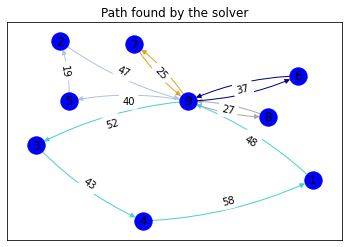

In [39]:
result = succ

#vehicles_used = result['vehiclesUsed']
# print(np.array(result['succ'])[:vehicles_used])
print('#'*10 + ' SOLUTION FOUND ' + '#'*20)
print(f'Distance Travelled: {distanceTravelled}')
print(f'Number of Vehicles used: {vehiclesUsed}')
print('#'*50)
paths = np.array(succ)[:vehiclesUsed]

# plot the graph
G = nx.DiGraph() 
G.add_nodes_from(node_names)

# add colours to the paths depending on which vehicle visits it
for vehicle_num in range(paths.shape[0]):
    for dest_num in range(paths.shape[1]):
        G.add_edge(dest_num+1,paths[vehicle_num,dest_num],weight=dist[dest_num][paths[vehicle_num,dest_num]-1], color=colors[vehicle_num])

edgelist = G.edges()
nodelist = G.nodes()
edge_colors = [G[u][v]['color'] for u,v in edgelist]
edge_labels = nx.get_edge_attributes(G,'weight')
############################################################
# nx.draw(G,pos=pos,with_labels=True, node_colors='light_blue', edge_colors=edge_colors,connectionstyle='arc3, rad = 0.1')
# nx.draw_networkx_edge_labels(G,pos=pos,edge_labels=labels)
############################################################
nx.draw_networkx_nodes(G,pos,nodelist=nodelist,node_color='b')
nx.draw_networkx_labels(G, pos, node_labels)
nx.draw_networkx_edges(G,pos,edgelist=edgelist,edge_color=edge_colors,connectionstyle='arc3, rad = 0.1')
nx.draw_networkx_edge_labels(G,pos=pos,edge_labels=edge_labels)
plt.title('Path found by the solver')
plt.show()
############################################################